In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
import time
from datetime import datetime
from tqdm.notebook import tqdm as tqdm_notebook
TQDM_AVAILABLE = True

# 1. Load all filtered anomalous data files
def load_anomalous_data(data_dir='filtered_data'):
    """Load and combine all filtered anomalous data files, adding location info."""
    all_files = glob.glob(f'{data_dir}/*_filtered.csv')
    data_frames = []
    
    # Add progress bar
    for file_path in tqdm(all_files, desc="Loading data files", leave=False):
        try:
            location = os.path.basename(file_path).replace('_filtered.csv', '')
            df = pd.read_csv(file_path)
            df['location'] = location
            data_frames.append(df)
            # Print without breaking the progress bar
            tqdm.write(f"Loaded {location} - {len(df)} rows")
        except Exception as e:
            tqdm.write(f"Error loading {file_path}: {e}")
    
    combined_df = pd.concat(data_frames, ignore_index=True)
    print(f"Total combined data: {len(combined_df)} rows")
    return combined_df

# 2. Preprocess and clean data
def preprocess_data(df):
    """Handle missing values, standardize columns, and prepare data."""
    print("\nPreprocessing data...")
    df = df.copy()
    df = df.groupby('location', group_keys=False).apply(
    lambda x: x.infer_objects(copy=False).interpolate(method='linear')
    )
    # Convert timestamp to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Ensure critical columns exist
    critical_cols = ['voltage', 'current', 'frequency', 'power', 'powerFactor']
    for col in critical_cols:
        if col not in df.columns:
            raise ValueError(f"Critical column '{col}' missing from data")
    
    # Handle missing values
    print(f"Missing values before: {df[critical_cols].isna().sum().sum()}")
    
    # Group by location and interpolate within each location
    df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
    
    # If any remaining NaNs, fill with median values by location
    for loc in df['location'].unique():
        loc_mask = df['location'] == loc
        for col in critical_cols:
            median_val = df.loc[loc_mask, col].median()
            df.loc[loc_mask, col] = df.loc[loc_mask, col].fillna(median_val)
    
    # Drop any rows that still have NaN in critical columns
    df = df.dropna(subset=critical_cols)
    print(f"Missing values after: {df[critical_cols].isna().sum().sum()}")
    print(f"Rows after handling missing values: {len(df)}")
    
    return df

# 3. Feature Engineering
def engineer_features(df):
    """Create detailed features to help distinguish anomaly types."""
    print("\nEngineering features...")
    df = df.copy()
    
    # Define nominal/ideal values for Philippines power systems
    NOMINAL_VOLTAGE = 230.0    # Nominal voltage for Philippines (V)
    IDEAL_FREQUENCY = 60.0     # Ideal frequency (Hz)
    IDEAL_POWER_FACTOR = 1.0   # Ideal power factor
    
    # Calculate deviations from nominal values
    df['voltage_deviation'] = (df['voltage'] - NOMINAL_VOLTAGE) / NOMINAL_VOLTAGE
    df['frequency_deviation'] = (df['frequency'] - IDEAL_FREQUENCY) / IDEAL_FREQUENCY
    df['pf_deviation'] = df['powerFactor'] - IDEAL_POWER_FACTOR
    
    # DETAILED VOLTAGE ANOMALY CATEGORIES
    df['severe_voltage_dip'] = ((df['voltage'] < 195.0)).astype(int)
    df['moderate_voltage_dip'] = ((df['voltage'] >= 195.0) & (df['voltage'] < 207.0)).astype(int)
    df['mild_voltage_dip'] = ((df['voltage'] >= 207.0) & (df['voltage'] < 217.4)).astype(int)
    
    df['mild_surge'] = ((df['voltage'] > 242.6) & (df['voltage'] <= 248.0)).astype(int)
    df['moderate_surge'] = ((df['voltage'] > 248.0) & (df['voltage'] <= 253.0)).astype(int)
    df['severe_surge'] = ((df['voltage'] > 253.0)).astype(int)
    
    # DETAILED POWER FACTOR ANOMALY CATEGORIES
    df['severe_pf_issue'] = ((df['powerFactor'] < 0.5)).astype(int)
    df['moderate_pf_issue'] = ((df['powerFactor'] >= 0.5) & (df['powerFactor'] < 0.7)).astype(int)
    df['mild_pf_issue'] = ((df['powerFactor'] >= 0.7) & (df['powerFactor'] < 0.792)).astype(int)
    
    # FREQUENCY ANOMALIES
    df['freq_low'] = ((df['frequency'] < 59.2)).astype(int)
    df['freq_high'] = ((df['frequency'] > 60.8)).astype(int)
    
    # LOAD AND POWER ANOMALIES
    df['high_current'] = (df['current'] > 10.0).astype(int)
    df['very_high_current'] = (df['current'] > 20.0).astype(int)
    df['high_power'] = (df['power'] > 1000.0).astype(int)
    df['very_high_power'] = (df['power'] > 3000.0).astype(int)
    
    # Original basic flags (for compatibility)
    df['transient_flag'] = ((df['voltage'] < 207.0) & (df['frequency'] > 59.0) & 
                           (df['frequency'] < 61.0)).astype(int)
    df['surge_flag'] = ((df['voltage'] > 248.0) & (df['frequency'] > 59.0) & 
                       (df['frequency'] < 61.0)).astype(int)
    df['pf_issue_flag'] = (df['powerFactor'] < 0.75).astype(int)
    
    # Create ratios (useful for detecting unusual load patterns)
    df['power_voltage_ratio'] = df['power'] / (df['voltage'] + 0.1)
    df['current_voltage_ratio'] = df['current'] / (df['voltage'] + 0.1)
    
    return df

# 4. Reduce data while preserving meaningful patterns
def reduce_data(df, max_samples=20000):
    """Reduce dataset size while ensuring balanced representation of anomaly types."""
    print("\nReducing data...")
    original_len = len(df)
    print(f"Processing {original_len:,} rows to reduce to {max_samples:,} samples")
    
    if len(df) <= max_samples:
        print(f"Data already small enough ({len(df):,} rows)")
        return df
    
    # STEP 1: Identify rows by anomaly type
    transient_rows = df[df['transient_flag'] == 1]
    surge_rows = df[df['surge_flag'] == 1]
    pf_issue_rows = df[df['pf_issue_flag'] == 1]
    print(f"Found {len(transient_rows)} transient anomalies")
    print(f"Found {len(surge_rows)} surge anomalies")
    print(f"Found {len(pf_issue_rows)} power factor issues")
    
    # STEP 2: Calculate samples for each category
    # Allocate samples: 20% transients, 20% surges, 30% PF issues, 30% normal data
    # If a category has fewer rows than its allocation, take all available and redistribute
    transient_target = int(max_samples * 0.2)  # 20% for transients
    surge_target = int(max_samples * 0.2)      # 20% for surges
    pf_issue_target = int(max_samples * 0.3)   # 30% for PF issues
    normal_target = max_samples - transient_target - surge_target - pf_issue_target  # Remaining for normal
    
    # Adjust if we don't have enough rows of a certain type
    transient_sample_size = min(len(transient_rows), transient_target)
    remainder = transient_target - transient_sample_size
    
    surge_target += remainder // 3
    pf_issue_target += remainder // 3
    normal_target += remainder - (2 * (remainder // 3))
    
    surge_sample_size = min(len(surge_rows), surge_target)
    remainder = surge_target - surge_sample_size
    
    pf_issue_target += remainder // 2
    normal_target += remainder - (remainder // 2)
    
    pf_issue_sample_size = min(len(pf_issue_rows), pf_issue_target)
    normal_target += (pf_issue_target - pf_issue_sample_size)
    
    # STEP 3: Sample from each category
    sampled_transients = transient_rows.sample(transient_sample_size, random_state=42) if transient_sample_size > 0 else pd.DataFrame()
    sampled_surges = surge_rows.sample(surge_sample_size, random_state=42) if surge_sample_size > 0 else pd.DataFrame()
    sampled_pf_issues = pf_issue_rows.sample(pf_issue_sample_size, random_state=42) if pf_issue_sample_size > 0 else pd.DataFrame()
    
    # STEP 4: Get normal data (not flagged by any anomaly)
    all_anomalies = pd.concat([sampled_transients, sampled_surges, sampled_pf_issues])
    normal_data = df[~((df['transient_flag'] == 1) | (df['surge_flag'] == 1) | (df['pf_issue_flag'] == 1))]
    
    # STEP 5: Create stratified sample of normal data by location
    normal_sample = pd.DataFrame()
    if len(normal_data) > 0 and normal_target > 0:
        for location in normal_data['location'].unique():
            loc_data = normal_data[normal_data['location'] == location]
            loc_proportion = len(loc_data) / len(normal_data)
            loc_sample_size = max(50, int(normal_target * loc_proportion))  # At least 50 from each location
            
            if len(loc_data) > 0:
                # Create voltage bins for stratified sampling
                loc_data = loc_data.copy()
                loc_data['voltage_bin'] = pd.qcut(loc_data['voltage'], 
                                                 q=min(10, len(loc_data)),
                                                 labels=False, 
                                                 duplicates='drop')
                
                loc_sample = pd.DataFrame()
                for bin_id in loc_data['voltage_bin'].unique():
                    bin_data = loc_data[loc_data['voltage_bin'] == bin_id]
                    bin_sample_size = max(1, int(loc_sample_size * len(bin_data) / len(loc_data)))
                    if len(bin_data) > 0:
                        bin_sample = bin_data.sample(min(bin_sample_size, len(bin_data)), random_state=42)
                        loc_sample = pd.concat([loc_sample, bin_sample])
                
                normal_sample = pd.concat([normal_sample, loc_sample])
    
    # If we still need more normal samples, add them randomly
    if len(normal_sample) < normal_target and len(normal_data) > 0:
        remaining_normal = normal_data[~normal_data.index.isin(normal_sample.index)]
        if len(remaining_normal) > 0:
            additional_samples = min(normal_target - len(normal_sample), len(remaining_normal))
            normal_sample = pd.concat([normal_sample, 
                                     remaining_normal.sample(additional_samples, random_state=42)])
    
    # STEP 6: Combine all samples
    reduced_df = pd.concat([sampled_transients, sampled_surges, sampled_pf_issues, normal_sample])
    
    # Ensure we don't exceed max_samples
    if len(reduced_df) > max_samples:
        reduced_df = reduced_df.sample(max_samples, random_state=42)
    
    print(f"Reduced data from {original_len:,} to {len(reduced_df):,} rows")
    print("\nAnomaly type distribution in sampled data:")
    print(f" - Transient anomalies: {sum(reduced_df['transient_flag'])} ({sum(reduced_df['transient_flag'])/len(reduced_df):.1%})")
    print(f" - Surge anomalies: {sum(reduced_df['surge_flag'])} ({sum(reduced_df['surge_flag'])/len(reduced_df):.1%})")
    print(f" - PF issues: {sum(reduced_df['pf_issue_flag'])} ({sum(reduced_df['pf_issue_flag'])/len(reduced_df):.1%})")
    print(f" - Normal data: {len(reduced_df) - sum(reduced_df['transient_flag'] | reduced_df['surge_flag'] | reduced_df['pf_issue_flag'])} ({(len(reduced_df) - sum(reduced_df['transient_flag'] | reduced_df['surge_flag'] | reduced_df['pf_issue_flag']))/len(reduced_df):.1%})")
    
    # Print location distribution
    loc_counts = reduced_df['location'].value_counts()
    print("\nSamples per location:")
    for loc, count in loc_counts.items():
        print(f" - {loc}: {count} rows")
        
    return reduced_df

# 5. Normalize/Scale data for clustering
def normalize_data(df, scaler_type='standard'):
    """Normalize numerical features for clustering."""
    print("\nNormalizing data...")
    
    # Select features for clustering
    feature_cols = [
        'voltage', 'current', 'frequency', 'power', 'powerFactor',
        'voltage_deviation', 'frequency_deviation', 'pf_deviation',
        'power_voltage_ratio', 'current_voltage_ratio'
    ]
    
    # Select appropriate scaler
    if scaler_type.lower() == 'standard':
        scaler = StandardScaler()
    elif scaler_type.lower() == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type.lower() == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")
    
    # Fit scaler and transform the data
    features = df[feature_cols].copy()
    scaled_features = scaler.fit_transform(features)
    
    # Create DataFrame with scaled features
    scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
    
    # Add location and flag columns (not scaled)
    for col in ['location', 'transient_flag', 'surge_flag', 'pf_issue_flag']:
        if col in df.columns:
            scaled_df[col] = df[col].values
    
    print(f"Data normalized using {scaler_type} scaling")
    return scaled_df, feature_cols, scaler

# 6. Visualize the data
def visualize_data(df, scaled_df, feature_cols):
    """Create visualizations with better performance."""
    print("\nCreating visualizations...")
    
    # Create output directory if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    
    # 1. Distribution of key parameters
    print("  Creating parameter distributions plot...")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(['voltage', 'current', 'frequency', 'power', 'powerFactor']):
        plt.subplot(2, 3, i+1)
        sample_size = min(5000, len(df))
        sns.histplot(df[col].sample(sample_size), kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig('plots/parameter_distributions.png')
    plt.close()
    
    # 2. Visualize patterns with PCA (2D projection)
    print("  Creating PCA projection plots...")
    pca = PCA(n_components=2)
    
    # Sample for PCA visualization
    sample_size = min(5000, len(scaled_df))
    sample_indices = np.random.choice(len(scaled_df), sample_size, replace=False)
    sampled_df = df.iloc[sample_indices]
    sampled_scaled_df = scaled_df.iloc[sample_indices]
    
    pca_result = pca.fit_transform(sampled_scaled_df[feature_cols])
    
    plt.figure(figsize=(12, 10))
    
    # Color by location - USING sampled_df
    print("  - Creating location PCA plot...")
    plt.subplot(2, 2, 1)
    for location in sampled_df['location'].unique():
        mask = sampled_df['location'] == location  # FIXED: using sampled_df
        if sum(mask) > 0:
            plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=location, alpha=0.6, s=10)
    plt.title('PCA Projection by Location')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    
    # Color by transient flag - USING sampled_df
    plt.subplot(2, 2, 2)
    for flag in [0, 1]:
        mask = sampled_df['transient_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'Transient: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Transient Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    # Color by surge flag - USING sampled_df
    plt.subplot(2, 2, 3)
    for flag in [0, 1]:
        mask = sampled_df['surge_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'Surge: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Voltage Surge Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    # Color by PF issue flag - USING sampled_df
    plt.subplot(2, 2, 4)
    for flag in [0, 1]:
        mask = sampled_df['pf_issue_flag'] == flag  # FIXED: using sampled_df
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=f'PF Issue: {"Yes" if flag else "No"}', 
                   alpha=0.6, s=10)
    plt.title('PCA Projection by Power Factor Issue Flag')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/pca_visualization.png')
    plt.close()  # Close the figure
    
    # 3. Correlation matrix of features
    print("  Creating correlation matrix...")
    plt.figure(figsize=(12, 10))
    corr_matrix = df[feature_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.savefig('plots/correlation_matrix.png')
    plt.close()  # Close the figure
    
    print("  Visualizations saved to 'plots' directory")
    return pca_result

def extract_score(metrics_df, n_clusters, score_column='silhouette'):
    """Extract a score for a given number of clusters from the metrics DataFrame."""
    if len(metrics_df) > 0 and score_column in metrics_df.columns and 'k' in metrics_df.columns:
        matching_rows = metrics_df[metrics_df['k'] == n_clusters]
        if not matching_rows.empty:
            return matching_rows.iloc[0][score_column]
    return float('nan')

def find_optimal_clusters(X, model_class, max_k=15, min_k=4, random_state=42, **model_params):
    """
    Find optimal number of clusters using multiple metrics for any clustering model.
    
    Parameters:
    - X: Feature matrix
    - model_class: The clustering class to use (e.g., KMeans, AgglomerativeClustering)
    - max_k: Maximum number of clusters to try
    - random_state: Random seed for reproducibility
    - **model_params: Additional parameters to pass to the model
    
    Returns:
    - optimal_k: Optimal number of clusters
    - metrics_by_k: DataFrame with metrics for each k value
    """
    print(f"\nFinding optimal clusters for {model_class.__name__} using multiple metrics...")
    metrics_by_k = pd.DataFrame(columns=['k', 'silhouette', 'davies_bouldin', 'calinski_harabasz'])
    
    for k in range(2, max_k+1):
        try:
            # Create model instance with current k
            if model_class == KMeans:
                model = model_class(n_clusters=k, random_state=random_state, **model_params)
            elif model_class == GaussianMixture:
                model = model_class(n_components=k, random_state=random_state, **model_params)
            elif model_class == SpectralClustering:
                # Use more robust parameters for Spectral Clustering
                model = model_class(
                    n_clusters=k, 
                    random_state=random_state,
                    affinity='rbf',  # More robust than nearest_neighbors
                    gamma=1.0,       # Control the width of the RBF kernel
                    **model_params
                )
            elif model_class == AgglomerativeClustering:
                model = model_class(n_clusters=k, **model_params)
            else:
                print(f"  Unsupported model class: {model_class.__name__}")
                return 2, pd.DataFrame()
            
            # Fit and get labels
            if hasattr(model, 'fit_predict'):
                labels = model.fit_predict(X)
            else:
                model.fit(X)
                labels = model.predict(X)
            
            # Calculate metrics
            sil_score = silhouette_score(X, labels)
            db_score = davies_bouldin_score(X, labels)
            ch_score = calinski_harabasz_score(X, labels)
            
            # Create new row
            new_row = pd.DataFrame({
                'k': [k],
                'silhouette': [sil_score],
                'davies_bouldin': [db_score],
                'calinski_harabasz': [ch_score]
            })
            
            # Proper concatenation to avoid warning
            if len(metrics_by_k) == 0:
                metrics_by_k = new_row
            else:
                # Proper concatenation with explicit dtypes
                metrics_by_k = pd.concat([metrics_by_k, new_row], ignore_index=True).astype({
                    'k': 'int64',
                    'silhouette': 'float64', 
                    'davies_bouldin': 'float64',
                    'calinski_harabasz': 'float64'
                })
            
            print(f"  k={k}: silhouette={sil_score:.4f}, davies_bouldin={db_score:.4f}, calinski_harabasz={ch_score:.2f}")
            
        except Exception as e:
            print(f"  Error with k={k}: {str(e)}")
    
    # Determine optimal k based on all metrics
    if len(metrics_by_k) == 0:
        print(f"  No valid clusters found for {model_class.__name__}. Using default k=2.")
        return 2, pd.DataFrame()
    
    # Find optimal k values for each metric
    best_k_silhouette = int(metrics_by_k.loc[metrics_by_k['silhouette'].idxmax()]['k'])
    best_k_davies = int(metrics_by_k.loc[metrics_by_k['davies_bouldin'].idxmin()]['k'])
    best_k_calinski = int(metrics_by_k.loc[metrics_by_k['calinski_harabasz'].idxmax()]['k'])
    
    print("\nBest k values by metric:")
    print(f"  Silhouette score: k={best_k_silhouette} (higher is better)")
    print(f"  Davies-Bouldin index: k={best_k_davies} (lower is better)")
    print(f"  Calinski-Harabasz index: k={best_k_calinski} (higher is better)")
    
    # Determine consensus optimal k
    optimal_k_votes = [best_k_silhouette, best_k_davies, best_k_calinski]
    from collections import Counter
    optimal_k_counter = Counter(optimal_k_votes)
    
    # If there's a clear winner with at least 2 votes, use it
    for k, votes in optimal_k_counter.items():
        if votes >= 2 and k >= min_k:  # Added min_k constraint
            optimal_k = k
            print(f"\nSelected k={optimal_k} based on majority vote from metrics")
            return optimal_k, metrics_by_k
    
    # If no majority vote meets minimum cluster count
    filtered_metrics = metrics_by_k[metrics_by_k['k'] >= min_k]
    if not filtered_metrics.empty:
        best_k_silhouette = int(filtered_metrics.loc[filtered_metrics['silhouette'].idxmax()]['k'])
        print(f"\nNo consensus meeting minimum cluster count, using silhouette score with k>={min_k}")
        optimal_k = best_k_silhouette
    else:
        print(f"\nFalling back to silhouette score without minimum constraint")
        optimal_k = best_k_silhouette  # Original optimal_k
    
    print(f"Final optimal k for {model_class.__name__}: {optimal_k}")
    return optimal_k, metrics_by_k

# 7. Perform clustering and evaluate
def perform_clustering(scaled_df, feature_cols, max_samples=100_000):
    """Perform clustering using multiple methods and evaluate results."""
    print("\nPerforming clustering analysis...")
    
    # If dataset is too large, take a balanced sample
    if len(scaled_df) > max_samples:
        print(f"Dataset has {len(scaled_df):,} samples, downsampling to {max_samples:,} for performance")
        scaled_df = scaled_df.sample(max_samples, random_state=42)
    
    # Prepare data for clustering
    X = scaled_df[feature_cols].values
    total_samples = X.shape[0]
    print(f"Clustering {total_samples:,} data points across {len(feature_cols)} features")
    
    # Define clustering model classes to try
    model_classes = {
        'KMeans': KMeans,
        'SpectralClustering': SpectralClustering,
        'AgglomerativeClustering': AgglomerativeClustering,
        'WardHierarchical': AgglomerativeClustering,
        'GaussianMixture': GaussianMixture
    }
    
    # # Initial call to find_optimal_clusters now returns metrics_df instead of score, _
    # n_clusters, _ = find_optimal_clusters(X, model_classes['KMeans'])
    
    # Create output directory for plots if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    
    # Store results for each model
    results = {}
    metrics_summary = []
    
    # For each clustering algorithm, find optimal clusters and evaluate
    for name, model_class in model_classes.items():
        print(f"\nEvaluating {name}...")
        
        # Different handling for different algorithms
        try:
            # For hierarchical methods, use a smaller sample
            if name in ['AgglomerativeClustering', 'WardHierarchical']:
                max_hier_samples = 20_000  # Limit to avoid memory issues 5000
                if X.shape[0] > max_hier_samples:
                    indices = np.random.choice(X.shape[0], max_hier_samples, replace=False)
                    X_reduced = X[indices]
                    print(f"Using reduced dataset of {max_hier_samples:,} samples for {name}")
                else:
                    X_reduced = X
                
                # Find optimal clusters (with ward linkage for WardHierarchical)
                if name == 'WardHierarchical':
                    print(f"\nFinding optimal clusters for Ward Hierarchical (AgglomerativeClustering with ward linkage)...")
                    n_clusters, metrics_df = find_optimal_clusters(X_reduced, model_class, linkage='ward')
                else:
                    n_clusters, metrics_df = find_optimal_clusters(X_reduced, model_class)
                
                # Extract silhouette score for display
                sil_score_value = extract_score(metrics_df, n_clusters)
                data_to_use = X_reduced
            
            # For SpectralClustering with better parameters and downsampling
            elif name == 'SpectralClustering':
                spectral_max_samples = min(20_000, X.shape[0]) # 8000
                if spectral_max_samples < X.shape[0]:
                    spectral_indices = np.random.choice(X.shape[0], spectral_max_samples, replace=False)
                    X_spectral = X[spectral_indices]
                    print(f"Using reduced dataset of {spectral_max_samples:,} samples for SpectralClustering")
                else:
                    X_spectral = X
                
                # Remove the affinity parameter here - let find_optimal_clusters handle it
                n_clusters, metrics_df = find_optimal_clusters(X_spectral, model_class, assign_labels='kmeans')
                
                # Extract silhouette score for display
                sil_score_value = extract_score(metrics_df, n_clusters)
                data_to_use = X_spectral
                
                # Extract silhouette score for display
                sil_score_value = extract_score(metrics_df, n_clusters)
                data_to_use = X_spectral
            
            # For KMeans and GaussianMixture, use full dataset
            else:
                n_clusters, metrics_df = find_optimal_clusters(X, model_class)
                # Extract silhouette score for display
                sil_score_value = extract_score(metrics_df, n_clusters)
                data_to_use = X
            
            print(f"  Optimal number of clusters for {name}: {n_clusters} (silhouette={sil_score_value:.4f})")
            
            # Create and fit model with optimal number of clusters
            start_time = time.time()
            print(f"  Fitting {name} with {n_clusters} clusters...")
            
            if name == 'KMeans':
                model = model_class(n_clusters=n_clusters, random_state=42, verbose=0)
            elif name == 'GaussianMixture':
                model = model_class(n_components=n_clusters, random_state=42, verbose=0)
            elif name == 'SpectralClustering':
                model = model_class(
                    n_clusters=n_clusters, 
                    random_state=42,
                    affinity='nearest_neighbors',
                    n_neighbors=10,
                    assign_labels='kmeans',
                    n_jobs=-1         
                )
            elif name == 'WardHierarchical':
                model = model_class(n_clusters=n_clusters, linkage='ward')
            elif name == 'AgglomerativeClustering':
                model = model_class(n_clusters=n_clusters)
            
            # Fit model and get cluster labels
            if hasattr(model, 'fit_predict'):
                print(f"  - Fitting and predicting with {name}...")
                labels = model.fit_predict(data_to_use)
            else:
                print(f"  - Fitting {name}...")
                model.fit(data_to_use)
                print(f"  - Predicting with {name}...")
                labels = model.predict(data_to_use)
            
            # If we used downsampled data for SpectralClustering, we need to
            # assign cluster labels to the full dataset
            if name == 'SpectralClustering' and len(X_spectral) < len(X):
                # Train a KNN classifier on the spectral clustering results
                from sklearn.neighbors import KNeighborsClassifier
                print(f"  - Extending SpectralClustering labels to full dataset...")
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_spectral, labels)
                
                # Use KNN to predict labels for the full dataset
                labels = knn.predict(X)
                print(f"  Extended {len(X_spectral):,} SpectralClustering labels to full dataset of {len(X):,} samples")
            
            # For hierarchical methods, extend to full dataset if needed
            if name in ['AgglomerativeClustering', 'WardHierarchical'] and len(X_reduced) < len(X):
                # Train a KNN classifier on the hierarchical clustering results
                from sklearn.neighbors import KNeighborsClassifier
                print(f"  - Extending {name} labels to full dataset...")
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_reduced, labels)
                
                # Use KNN to predict labels for the full dataset
                labels = knn.predict(X)
                print(f"  Extended {len(X_reduced):,} {name} labels to full dataset of {len(X):,} samples")
            
            # Calculate evaluation metrics
            metrics = {}
            print("  - Calculating evaluation metrics...")
            
            try:
                print("    - Computing Silhouette Score...")
                metrics['silhouette'] = silhouette_score(X, labels)
            except Exception as e:
                print(f"    - Silhouette Score failed: {str(e)}")
                metrics['silhouette'] = float('nan')
                
            try:
                print("    - Computing Davies-Bouldin Index...")
                metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
            except Exception as e:
                print(f"    - Davies-Bouldin Index failed: {str(e)}")
                metrics['davies_bouldin'] = float('nan')
                
            try:
                print("    - Computing Calinski-Harabasz Index...")
                metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
            except Exception as e:
                print(f"    - Calinski-Harabasz Index failed: {str(e)}")
                metrics['calinski_harabasz'] = float('nan')
            
            # Store results
            results[name] = {
                'labels': labels,
                'metrics': metrics
            }
            
            # Calculate and display time taken
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_str = f"{int(elapsed_time // 60)} mins {int(elapsed_time % 60)} secs"
            
            print(f"  {name} completed in {time_str}")
            print(f"  Silhouette: {metrics['silhouette']:.4f}")
            print(f"  Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
            print(f"  Calinski-Harabasz: {metrics['calinski_harabasz']:.4f}")
            
            # Add to metrics summary
            metrics_summary.append({
                'model_name': name,
                'n_clusters': n_clusters,
                'silhouette': metrics['silhouette'],
                'davies_bouldin': metrics['davies_bouldin'],
                'calinski_harabasz': metrics['calinski_harabasz'],
                'time': elapsed_time
            })
            
            # Generate PCA visualization
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            
            plt.figure(figsize=(10, 8))
            for cluster_id in range(n_clusters):
                cluster_mask = labels == cluster_id
                if np.any(cluster_mask):  # Only plot if cluster has points
                    plt.scatter(
                        X_pca[cluster_mask, 0],
                        X_pca[cluster_mask, 1],
                        alpha=0.7, s=15
                    )
            
            plt.title(f'PCA Visualization of {name} with {n_clusters} Clusters')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.grid(alpha=0.3)
            plt.savefig(f'plots/pca_clusters_{name}_{n_clusters}.png')
            plt.close()
            
        except Exception as e:
            print(f"  Error with {name}: {str(e)}")
    
    # Create dataframe of metrics for comparison
    metrics_df = pd.DataFrame(metrics_summary)
    
    if len(metrics_df) > 0:
        # Find best model based on silhouette score
        best_idx = metrics_df['silhouette'].idxmax()
        best_model = metrics_df.loc[best_idx, 'model_name']
        
        # Create a more readable metrics DataFrame for display
        metrics_display = pd.DataFrame({
            name: {
                'Silhouette Score': results[name]['metrics']['silhouette'],
                'Davies-Bouldin Index': results[name]['metrics']['davies_bouldin'],
                'Calinski-Harabasz Index': results[name]['metrics']['calinski_harabasz']
            } for name in results
        })
        
        # Add best cluster labels to df
        scaled_df['cluster'] = results[best_model]['labels']
        
        print(f"\nBest clustering model: {best_model}")
        print(metrics_display[best_model])
        
        return results, metrics_display, best_model
    else:
        print("No valid clustering results found.")
        return {}, pd.DataFrame(), "KMeans"

# 8. Analyze clusters
def analyze_clusters(df, scaled_df, results, best_model):
    """Analyze the clusters to determine what they represent."""
    print("\nAnalyzing clusters...")
    
    # Display information about the chosen model
    print(f"Using best clustering model: {best_model}")
    print("Model metrics:")
    if 'metrics' in results[best_model]:
        metrics = results[best_model]['metrics']
        print(f"  Silhouette Score:        {metrics['silhouette']:.4f}")
        print(f"  Davies-Bouldin Index:    {metrics['davies_bouldin']:.4f}")
        print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']:.2f}")
    
    cluster_labels = results[best_model]['labels']
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Count samples per cluster
    cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
    print("Samples per cluster:")
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} samples ({count/len(df_with_clusters):.1%})")
    
    # Calculate cluster profiles - INCLUDE ALL DETAILED ANOMALY CATEGORIES
    cluster_profiles = df_with_clusters.groupby('cluster')[
        ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
        'transient_flag', 'surge_flag', 'pf_issue_flag',
        'severe_voltage_dip', 'moderate_voltage_dip', 'mild_voltage_dip',
        'mild_surge', 'moderate_surge', 'severe_surge', 
        'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue',
        'freq_low', 'freq_high',
        'high_current', 'very_high_current', 'high_power', 'very_high_power',
        'voltage_deviation', 'frequency_deviation', 'pf_deviation',  # Add these three lines
        'power_voltage_ratio', 'current_voltage_ratio'              # Add derived ratios too
        ]
    ].mean()
    
    print("\nCluster profiles:")
    print(cluster_profiles)
    
    # Create 2D visualization of clusters with PCA
    pca = PCA(n_components=2)
    X = scaled_df.drop(columns=['location', 'transient_flag', 'surge_flag', 'pf_issue_flag', 'cluster']).values
    pca_result = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    for cluster in np.unique(cluster_labels):
        plt.scatter(
            pca_result[cluster_labels == cluster, 0],
            pca_result[cluster_labels == cluster, 1],
            label=f'Cluster {cluster}', alpha=0.7, s=15
        )
    
    plt.title(f'Clustering Results with {best_model}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/clustering_{best_model}.png')
    
    # Map clusters to anomaly types with detailed categories
    anomaly_mapping = {}
    for cluster in cluster_profiles.index:
        profile = cluster_profiles.loc[cluster]
        
        # Start with most severe conditions and work down
        if profile['current'] < 0.01 and profile['power'] < 1.0:
            anomaly_type = "No Load (Idle Operation)"
        # Light load with acceptable PF
        elif profile['current'] < 2.0 and profile['power'] < 400.0 and profile['powerFactor'] >= 0.75:
            anomaly_type = "Light Load (Normal Operation)"
        # Then continue with your existing conditions
        elif profile['severe_voltage_dip'] > 0.3:
            anomaly_type = "Severe Voltage Dip"
        elif profile['severe_surge'] > 0.3:
            anomaly_type = "Severe Voltage Surge"
        elif profile['very_high_power'] > 0.5 and profile['powerFactor'] > 0.9:
            anomaly_type = "Very High Load (Good PF)"
        elif profile['very_high_power'] > 0.5 and profile['powerFactor'] < 0.75:
            anomaly_type = "Very High Load with PF Issues"
        elif profile['high_current'] > 0.5 and profile['moderate_pf_issue'] > 0.5:
            anomaly_type = "High Current with PF Issues"
        elif profile['moderate_voltage_dip'] > 0.3:
            anomaly_type = "Moderate Voltage Dip"
        elif profile['moderate_surge'] > 0.3:
            anomaly_type = "Moderate Voltage Surge"
        elif profile['severe_pf_issue'] > 0.3:
            anomaly_type = "Severe Power Factor Issue"
        elif profile['moderate_pf_issue'] > 0.5:
            anomaly_type = "Moderate Power Factor Issue"
        elif profile['mild_pf_issue'] > 0.5:
            anomaly_type = "Mild Power Factor Issue"
        elif profile['freq_low'] > 0.3:
            anomaly_type = "Low Frequency"
        elif profile['freq_high'] > 0.3:
            anomaly_type = "High Frequency"
        elif (profile['power'] > 1000 and profile['current'] > 5):
            anomaly_type = "High Load Operation"
        elif profile['pf_deviation'] > 0.1:
            anomaly_type = "Minor Power Factor Deviation"
        else:
            anomaly_type = "Normal Operation"
        
        anomaly_mapping[cluster] = anomaly_type
    
    print("\nCluster to anomaly type mapping:")
    for cluster, anomaly_type in anomaly_mapping.items():
        print(f"  Cluster {cluster} → {anomaly_type}")
    
    # Save results for further analysis
    df_with_clusters['anomaly_type'] = df_with_clusters['cluster'].map(anomaly_mapping)
    df_with_clusters.to_csv('clustered_anomalies.csv', index=False)
    
    return df_with_clusters, anomaly_mapping

=== Power Quality Anomaly Analysis ===
Started at: 2025-05-01 17:37:24


Analysis progress:   0%|          | 0/7 [00:00<?, ?it/s]


Loading data files:   0%|                                                                       | 0/12 [00:00<?, ?it/s]
                                                                                                                    
Loading data files:   8%|█████▎                                                         | 1/12 [00:00<00:02,  4.90it/s]

Loaded Bato - 131499 rows



                                                                                                                    
Loading data files:  17%|██████████▌                                                    | 2/12 [00:01<00:07,  1.34it/s]

Loaded Busay - 663099 rows



                                                                                                                    
Loading data files:  25%|███████████████▊                                               | 3/12 [00:01<00:05,  1.50it/s]

Loaded Kodia - 561491 rows



                                                                                                                    
Loading data files:  33%|█████████████████████                                          | 4/12 [00:02<00:04,  1.83it/s]

Loaded Lorega - 192232 rows



                                                                                                                    
Loading data files:  42%|██████████████████████████▎                                    | 5/12 [00:03<00:05,  1.27it/s]

Loaded Naga - 678014 rows



                                                                                                                    
Loading data files:  50%|███████████████████████████████▌                               | 6/12 [00:03<00:03,  1.61it/s]
                                                                                                                    
Loading data files:  58%|████████████████████████████████████▊                          | 7/12 [00:03<00:02,  2.18it/s]

Loaded Poblacion - 261193 rows
Loaded Pusok - 53154 rows



                                                                                                                    
Loading data files:  67%|██████████████████████████████████████████                     | 8/12 [00:04<00:01,  2.13it/s]
                                                                                                                    
Loading data files:  67%|██████████████████████████████████████████                     | 8/12 [00:04<00:01,  2.13it/s]
                                                                                                                    
Loading data files:  83%|███████████████████████████████████████████████████▋          | 10/12 [00:04<00:00,  3.71it/s]

Loaded SanFernando - 277521 rows
Loaded Talamban - 32157 rows
Loaded Ticad - 6018 rows



                                                                                                                    
Loading data files:  92%|████████████████████████████████████████████████████████▊     | 11/12 [00:05<00:00,  2.95it/s]

Loaded Tinago - 273387 rows



                                                                                                                    
Loading data files: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.34it/s]
                                                                                                                       

Loaded Tugas - 591565 rows
Total combined data: 3721330 rows
Step 1 completed in 6.2 seconds

Preprocessing data...


C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:46: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda x: x.infer_objects(copy=False).interpolate(method='linear')
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:46: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda x: x.infer_objects(copy=False).interpolate(method='linear')
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:46: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda x: x.infer_objects(copy=False).interpolate(method='linear')
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:46: FutureWarni

Missing values before: 0


C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:62: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:62: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\1043147426.py:62: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby('location').apply(lambda x: x.interpolate(method='linear'))
C:\Users\Alvin\AppData\Local\Temp\ipykernel_18636\10

Missing values after: 0
Rows after handling missing values: 3721330
Step 2 completed in 52.0 seconds

[Step 3/8] Engineering features...

Engineering features...
Step 3 completed in 0.9 seconds

[Step 4/8] Reducing data...

Reducing data...
Processing 3,721,330 rows to reduce to 20,000 samples
Found 95912 transient anomalies
Found 280 surge anomalies
Found 2961301 power factor issues
Reduced data from 3,721,330 to 20,000 rows

Anomaly type distribution in sampled data:
 - Transient anomalies: 4065 (20.3%)
 - Surge anomalies: 280 (1.4%)
 - PF issues: 9188 (45.9%)
 - Normal data: 7875 (39.4%)

Samples per location:
 - Tugas: 7396 rows
 - Lorega: 2441 rows
 - Naga: 1909 rows
 - Kodia: 1888 rows
 - Busay: 1852 rows
 - Bato: 1204 rows
 - Tinago: 811 rows
 - SanFernando: 792 rows
 - Poblacion: 709 rows
 - Pusok: 593 rows
 - Talamban: 350 rows
 - Ticad: 55 rows
Step 4 completed in 3.8 seconds

[Step 5/8] Normalizing data...

Normalizing data...
Data normalized using standard scaling
Step 5 co

C:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  - Calculating evaluation metrics...
    - Computing Silhouette Score...
    - Computing Davies-Bouldin Index...
    - Computing Calinski-Harabasz Index...
  SpectralClustering completed in 1 mins 53 secs
  Silhouette: -0.0949
  Davies-Bouldin: 1.9033
  Calinski-Harabasz: 37.6775

Evaluating AgglomerativeClustering...

Finding optimal clusters for AgglomerativeClustering using multiple metrics...
  k=2: silhouette=0.4819, davies_bouldin=1.0638, calinski_harabasz=10670.83
  k=3: silhouette=0.3240, davies_bouldin=1.0145, calinski_harabasz=10231.76
  k=4: silhouette=0.3817, davies_bouldin=0.9586, calinski_harabasz=10853.83
  k=5: silhouette=0.4038, davies_bouldin=0.9428, calinski_harabasz=12650.45
  k=6: silhouette=0.4418, davies_bouldin=0.8575, calinski_harabasz=14449.26
  k=7: silhouette=0.4559, davies_bouldin=0.8088, calinski_harabasz=14681.58
  k=8: silhouette=0.4776, davies_bouldin=0.7639, calinski_harabasz=15270.67
  k=9: silhouette=0.4638, davies_bouldin=0.8262, calinski_harabasz=

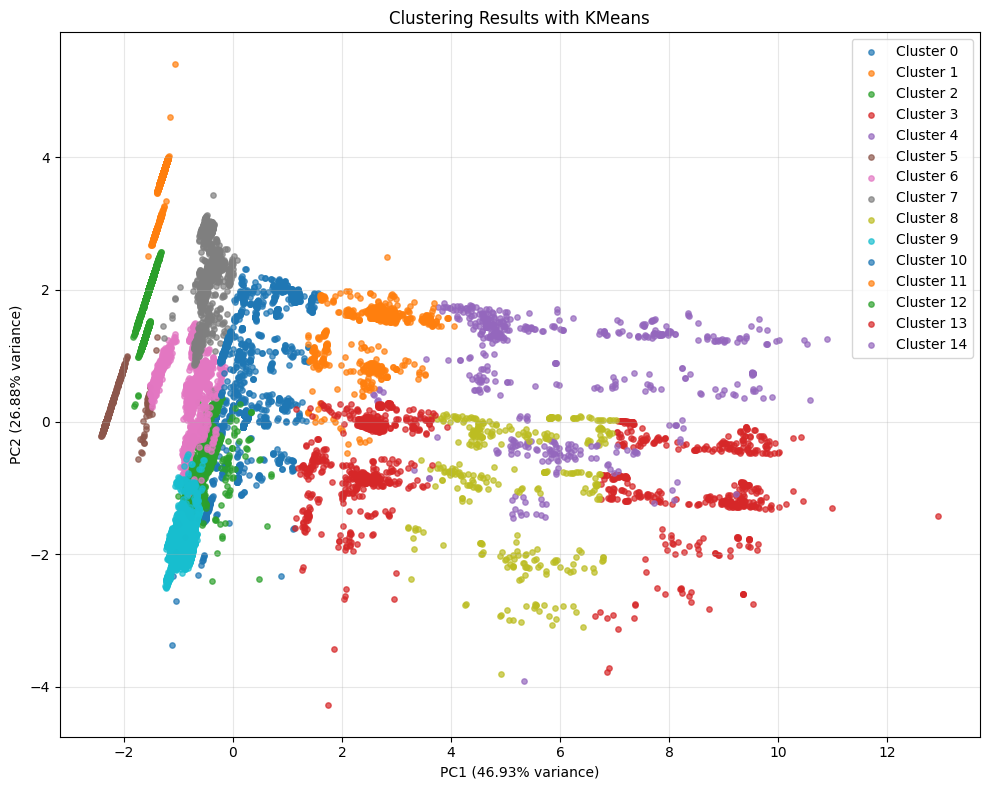

In [2]:
print("=== Power Quality Anomaly Analysis ===")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
overall_start = time.time()
max_samples = 20_000
# Create progress bar for main steps
main_steps = ["Loading data", "Preprocessing", "Feature engineering", 
              "Data reduction", "Normalization", "Clustering", "Analysis"]
main_pbar = tqdm_notebook(main_steps, desc="Analysis progress")

# 1. Load data
step_start = time.time()
main_pbar.set_description("Loading data")
df = load_anomalous_data()
print(f"Step 1 completed in {time.time() - step_start:.1f} seconds")
main_pbar.update(1)

# 2. Preprocess data
step_start = time.time()
main_pbar.set_description("Preprocessing data")
df = preprocess_data(df)
print(f"Step 2 completed in {time.time() - step_start:.1f} seconds")
main_pbar.update(1)

# 3. Engineer features
step_start = time.time()
print("\n[Step 3/8] Engineering features...")
df = engineer_features(df)
print(f"Step 3 completed in {time.time() - step_start:.1f} seconds")

# 4. Reduce data while preserving patterns
step_start = time.time()
print("\n[Step 4/8] Reducing data...")
df_reduced = reduce_data(df, max_samples=max_samples)  # Changed to 20,000 as per your suggestion
print(f"Step 4 completed in {time.time() - step_start:.1f} seconds")

# 5. Normalize data
step_start = time.time()
print("\n[Step 5/8] Normalizing data...")
scaled_df, feature_cols, scaler = normalize_data(df_reduced)
print(f"Step 5 completed in {time.time() - step_start:.1f} seconds")

# # 6. Visualize data
# step_start = time.time()
# print("\n[Step 6/8] Creating visualizations...")
# pca_result = visualize_data(df_reduced, scaled_df, feature_cols)
# print(f"Step 6 completed in {time.time() - step_start:.1f} seconds")

# 7. Perform clustering and evaluate
step_start = time.time()
print("\n[Step 7/8] Performing clustering analysis...")
results, metrics_df, best_model = perform_clustering(scaled_df, feature_cols)
print(f"Step 7 completed in {time.time() - step_start:.1f} seconds")

# 8. Analyze clusters
step_start = time.time()
print("\n[Step 8/8] Analyzing clusters...")
df_with_clusters, anomaly_mapping = analyze_clusters(df_reduced, scaled_df, results, best_model)
print(f"Step 8 completed in {time.time() - step_start:.1f} seconds")

overall_time = time.time() - overall_start
hours = int(overall_time // 3600)
minutes = int((overall_time % 3600) // 60)
seconds = int(overall_time % 60)

print("\nSummary:")
print(f"Best clustering model: {best_model}")
if 'metrics' in results[best_model]:
    metrics = results[best_model]['metrics']
    print(f"  Silhouette Score:        {metrics['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index:    {metrics['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']:.2f}")
print(f"Number of clusters: {len(anomaly_mapping)}")
print(f"Total samples: {len(df_with_clusters):,}")
print(f"Data used: {max_samples}")

print("\n=== Analysis Complete ===")
print(f"Total execution time: {hours}h {minutes}m {seconds}s")
print(f"Results saved to 'clustered_anomalies.csv'")
print(f"Visualizations saved to 'plots/' directory")
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [3]:
df_with_clusters.head()

timestamp  current  frequency  power  powerFactor  \
location                                                                        
Tugas     3158488 2025-04-14 19:02:19    0.401       60.0   65.4         0.79   
Busay     333760  2025-03-10 10:15:18    1.305       60.0  175.1         0.56   
Poblacion 2328103 2025-04-17 06:48:47    0.000       60.0    0.0         0.00   
Tugas     3230831 2025-04-15 20:55:26    0.206       60.0   33.2         0.78   
          3704822 2025-04-21 18:15:53    0.216       60.0   34.4         0.78   

                   voltage  anomalous   location  time_diff  latency  ...  \
location                                                              ...   
Tugas     3158488    207.5          1      Tugas        NaN      NaN  ...   
Busay     333760     239.6          1      Busay        1.0      1.0  ...   
Poblacion 2328103    240.6          1  Poblacion        NaN      NaN  ...   
Tugas     3230831    207.9          1      Tugas        NaN      NaN  ...   
          3704822    203.9          1      Tugas        NaN      NaN  ...   

                   high_power very_high_power transient_flag surge_flag  \
location                                                                  
Tugas     3158488           0               0              0          0   
Busay     333760            0               0              0          0   
Poblacion 2328103           0               0              0          0   
Tugas     3230831           0               0              0          0   
          3704822           0               0              1          0   

                  pf_issue_flag power_voltage_ratio  current_voltage_ratio  \
location                                                                     
Tugas     3158488             0            0.315029               0.001932   
Busay     333760              1            0.730496               0.005444   
Poblacion 2328103             1            0.000000               0.000000   
Tugas     3230831             0            0.159615               0.000990   
          3704822             0            0.168627               0.001059   

                   voltage_bin  cluster                   anomaly_type  
location                                                                
Tugas     3158488          0.0        9  Light Load (Normal Operation)  
Busay     333760           NaN        6      Severe Power Factor Issue  
Poblacion 2328103          NaN       12       No Load (Idle Operation)  
Tugas     3230831          0.0        9  Light Load (Normal Operation)  
          3704822          NaN        9  Light Load (Normal Operation)  

[5 rows x 42 columns]

In [4]:
df_with_clusters.columns

Index(['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage',
       'anomalous', 'location', 'time_diff', 'latency', 'expected_power',
       'power_mismatch', 'powerFactor_efficiency', 'voltage_violation',
       'no_load', 'all_zero', 'voltage_deviation', 'frequency_deviation',
       'pf_deviation', 'severe_voltage_dip', 'moderate_voltage_dip',
       'mild_voltage_dip', 'mild_surge', 'moderate_surge', 'severe_surge',
       'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue', 'freq_low',
       'freq_high', 'high_current', 'very_high_current', 'high_power',
       'very_high_power', 'transient_flag', 'surge_flag', 'pf_issue_flag',
       'power_voltage_ratio', 'current_voltage_ratio', 'voltage_bin',
       'cluster', 'anomaly_type'],
      dtype='object')

In [5]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 3, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].head()

timestamp  current  frequency   power  powerFactor  \
location                                                                        
Lorega   1545164 2025-03-27 12:24:32   16.641       60.1  4068.4         0.99   
         1542490 2025-03-27 11:02:13   22.014       60.1  5412.8         0.99   
         1542080 2025-03-27 10:51:28   21.635       60.1  5251.4         0.99   
         1476566 2025-03-24 14:13:23   20.815       60.1  5027.2         0.99   
         1517772 2025-03-26 12:17:41   22.726       60.0  5492.3         0.99   

                  voltage location  
location                            
Lorega   1545164    248.2   Lorega  
         1542490    248.6   Lorega  
         1542080    245.4   Lorega  
         1476566    244.3   Lorega  
         1517772    243.5   Lorega

In [6]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 4, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].describe()

,timestamp,current,frequency,power,powerFactor,voltage
count,315,315.000000,315.000000,315.000000,315.000000,315.000000
mean,2025-03-24 10:57:34.146031872,12.814667,59.817778,2613.014921,0.884825,231.458413
min,2025-03-20 10:34:42,8.626000,59.800000,1433.900000,0.730000,152.300000
25%,2025-03-21 21:11:06,11.348000,59.800000,2361.850000,0.780000,216.850000
50%,2025-03-24 18:28:17,13.122000,59.800000,2530.100000,0.980000,236.000000
75%,2025-03-26 14:19:39,13.855500,59.800000,2930.950000,0.980000,242.700000
max,2025-03-27 16:49:14,19.671000,59.900000,3422.700000,0.990000,248.100000
std,NaN,1.764507,0.038293,417.454585,0.103016,12.661618


In [7]:
df_with_clusters.loc[df_with_clusters['cluster'] == 4].describe()

,timestamp,current,frequency,power,powerFactor,voltage,anomalous,time_diff,latency,expected_power,...,very_high_current,high_power,very_high_power,transient_flag,surge_flag,pf_issue_flag,power_voltage_ratio,current_voltage_ratio,voltage_bin,cluster
count,315,315.000000,315.000000,315.000000,315.000000,315.000000,315.0,86.000000,86.000000,86.000000,...,315.0,315.0,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,308.000000,315.0
mean,2025-03-24 10:57:34.146031872,12.814667,59.817778,2613.014921,0.884825,231.458413,1.0,1.325581,1.325581,2731.733066,...,0.0,1.0,0.219048,0.003175,0.015873,0.006349,11.350646,0.055789,3.301948,4.0
min,2025-03-20 10:34:42,8.626000,59.800000,1433.900000,0.730000,152.300000,1.0,1.000000,1.000000,2187.002109,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,6.574507,0.039214,0.000000,4.0
25%,2025-03-21 21:11:06,11.348000,59.800000,2361.850000,0.780000,216.850000,1.0,1.000000,1.000000,2477.462663,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,9.970506,0.047561,1.000000,4.0
50%,2025-03-24 18:28:17,13.122000,59.800000,2530.100000,0.980000,236.000000,1.0,1.000000,1.000000,2569.795886,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,10.618112,0.055322,4.000000,4.0
75%,2025-03-26 14:19:39,13.855500,59.800000,2930.950000,0.980000,242.700000,1.0,2.000000,2.000000,2952.508903,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,13.124899,0.061980,5.000000,4.0
max,2025-03-27 16:49:14,19.671000,59.900000,3422.700000,0.990000,248.100000,1.0,4.000000,4.000000,3386.279064,...,0.0,1.0,1.000000,1.000000,1.000000,1.000000,15.919070,0.129075,9.000000,4.0
std,NaN,1.764507,0.038293,417.454585,0.103016,12.661618,0.0,0.562387,0.562387,314.144657,...,0.0,0.0,0.414259,0.056344,0.125183,0.079555,2.140889,0.010404,2.444777,0.0


In [8]:
# def evaluate_clusters(df, scaled_df, feature_cols, n_clusters_list=[18, 20, 25], min_pct=0.01, random_state=42):
#     """
#     Evaluate clustering with specific numbers of clusters.
    
#     Parameters:
#     - df: Original dataframe with raw features
#     - scaled_df: Scaled dataframe for clustering
#     - feature_cols: Feature columns used for clustering
#     - n_clusters_list: List of cluster counts to evaluate
#     - min_pct: Minimum percentage of points a cluster should have
#     - random_state: Random seed for reproducibility
    
#     Returns:
#     - Dictionary containing results for each n_clusters value
#     """
#     results = {}
#     X = scaled_df[feature_cols].values
#     metrics_df = pd.DataFrame(columns=['n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz'])
    
#     print("Evaluating specific cluster counts...")
    
#     for n_clusters in tqdm(n_clusters_list, desc="Evaluating clusters"):
#         print(f"\nEvaluating n_clusters={n_clusters}...")
        
#         # Create and fit KMeans model
#         model = KMeans(n_clusters=n_clusters, random_state=random_state, verbose=0)
#         start_time = time.time()
#         # Add a progress spinner for long computations
#         with tqdm(total=100, desc="Fitting KMeans", bar_format="{desc}: {percentage:3.0f}%|{bar}| {elapsed}s") as pbar:
#             labels = model.fit_predict(X)
#             pbar.update(100)  # Complete the progress bar
            
#         elapsed_time = time.time() - start_time
        
#         # Calculate metrics
#         silhouette = silhouette_score(X, labels)
#         davies_bouldin = davies_bouldin_score(X, labels)
#         calinski_harabasz = calinski_harabasz_score(X, labels)
        
#         # Store metrics
#         metrics_df = pd.concat([metrics_df, pd.DataFrame({
#             'n_clusters': [n_clusters],
#             'silhouette': [silhouette],
#             'davies_bouldin': [davies_bouldin],
#             'calinski_harabasz': [calinski_harabasz]
#         })], ignore_index=True)
        
#         print(f"  Silhouette: {silhouette:.4f}")
#         print(f"  Davies-Bouldin: {davies_bouldin:.4f}")
#         print(f"  Calinski-Harabasz: {calinski_harabasz:.4f}")
#         print(f"  Completed in {elapsed_time:.2f} seconds")
        
#         # Add labels to dataframe for this n_clusters
#         df_with_clusters = df.copy()
#         df_with_clusters['cluster'] = labels
        
#         # Analyze cluster sizes
#         cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
#         small_clusters = cluster_counts[cluster_counts / len(df_with_clusters) < min_pct]
        
#         print(f"  Cluster sizes range from {cluster_counts.min()} to {cluster_counts.max()} samples")
#         if len(small_clusters) > 0:
#             print(f"  Warning: {len(small_clusters)} clusters have less than {min_pct:.1%} of data:")
#             for cluster, count in small_clusters.items():
#                 print(f"    - Cluster {cluster}: {count} samples ({count/len(df_with_clusters):.2%})")
        
#         # Calculate cluster profiles for key metrics
#         cluster_profiles = df_with_clusters.groupby('cluster')[
#             ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
#              'severe_voltage_dip', 'moderate_voltage_dip', 'severe_surge',
#              'severe_pf_issue', 'moderate_pf_issue', 'pf_deviation']
#         ].mean()
        
#         print("\nCluster centroids (key metrics):")
#         print(cluster_profiles[['voltage', 'current', 'power', 'powerFactor']].round(2))
        
#         # Store results for this n_clusters
#         results[n_clusters] = {
#             'labels': labels,
#             'metrics': {
#                 'silhouette': silhouette,
#                 'davies_bouldin': davies_bouldin,
#                 'calinski_harabasz': calinski_harabasz
#             },
#             'cluster_counts': cluster_counts,
#             'small_clusters': small_clusters,
#             'cluster_profiles': cluster_profiles,
#             'model': model
#         }
        
#         # Plot cluster sizes
#         plt.figure(figsize=(12, 6))
#         ax = cluster_counts.plot(kind='bar')
#         plt.axhline(y=min_pct * len(df_with_clusters), color='r', linestyle='--', 
#                    label=f'Minimum size ({min_pct:.1%} of data)')
#         plt.title(f'Cluster Sizes (n_clusters={n_clusters})')
#         plt.xlabel('Cluster')
#         plt.ylabel('Number of Samples')
#         plt.legend()
#         plt.grid(axis='y', alpha=0.3)
#         plt.savefig(f'plots/cluster_sizes_{n_clusters}.png')
        
#         # Visualize clusters with PCA
#         pca = PCA(n_components=2)
#         X_pca = pca.fit_transform(X)
        
#         plt.figure(figsize=(10, 8))
#         for cluster in range(n_clusters):
#             plt.scatter(
#                 X_pca[labels == cluster, 0],
#                 X_pca[labels == cluster, 1],
#                 alpha=0.7, s=15
#             )
        
#         plt.title(f'PCA Visualization of {n_clusters} Clusters')
#         plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
#         plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
#         plt.grid(alpha=0.3)
#         plt.savefig(f'plots/pca_clusters_{n_clusters}.png')
    
#     # Compare metrics across different n_clusters
#     plt.figure(figsize=(15, 10))
    
#     plt.subplot(3, 1, 1)
#     plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], 'o-')
#     plt.title('Silhouette Score (higher is better)')
#     plt.grid(alpha=0.3)
    
#     plt.subplot(3, 1, 2)
#     plt.plot(metrics_df['n_clusters'], metrics_df['davies_bouldin'], 'o-')
#     plt.title('Davies-Bouldin Index (lower is better)')
#     plt.grid(alpha=0.3)
    
#     plt.subplot(3, 1, 3)
#     plt.plot(metrics_df['n_clusters'], metrics_df['calinski_harabasz'], 'o-')
#     plt.title('Calinski-Harabasz Index (higher is better)')
#     plt.grid(alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig('plots/clustering_metrics_comparison.png')
    
#     # Print summary table
#     print("\nMetrics summary:")
#     print(metrics_df.set_index('n_clusters'))
    
#     # Determine best n_clusters based on metrics
#     best_silhouette = metrics_df.loc[metrics_df['silhouette'].idxmax()]['n_clusters']
#     best_davies = metrics_df.loc[metrics_df['davies_bouldin'].idxmin()]['n_clusters']
#     best_ch = metrics_df.loc[metrics_df['calinski_harabasz'].idxmax()]['n_clusters']
    
#     print(f"\nOptimal n_clusters:")
#     print(f"  Based on Silhouette Score: {int(best_silhouette)}")
#     print(f"  Based on Davies-Bouldin Index: {int(best_davies)}")
#     print(f"  Based on Calinski-Harabasz Index: {int(best_ch)}")
    
#     return results, metrics_df

In [9]:
# # After your preprocessing, feature engineering, and normalizing steps
# # Run the evaluation on specific cluster counts
# cluster_results, metrics_summary = evaluate_clusters(
#     df_reduced, 
#     scaled_df, 
#     feature_cols,
#     n_clusters_list=[18, 20, 25]
# )

# # To select the best model from results
# best_n = int(metrics_summary.loc[metrics_summary['silhouette'].idxmax()]['n_clusters'])
# print(f"Best number of clusters based on silhouette: {best_n}")

# # Use the best model
# best_model = cluster_results[best_n]['model']
# df_with_clusters = df_reduced.copy()
# df_with_clusters['cluster'] = cluster_results[best_n]['labels']

# # Continue with your anomaly mapping
# # df_with_clusters['anomaly_type'] = ...

In [10]:
# Assuming your DataFrame is named df

df_with_clusters.loc[df_with_clusters['cluster'] == 12, ['timestamp', 'current', 'frequency', 'power', 'powerFactor', 'voltage', 'location']].head()

timestamp  current  frequency  power  powerFactor  \
location                                                                        
Poblacion 2328103 2025-04-17 06:48:47      0.0       60.0    0.0          0.0   
Tinago    3095118 2025-03-09 14:53:10      0.0       60.0    0.0          0.0   
Busay     702634  2025-03-16 16:04:42      0.0       60.1    0.0          0.0   
Poblacion 2476500 2025-04-21 06:47:47      0.0       60.0    0.0          0.0   
          2238683 2025-04-15 01:17:10      0.0       60.0    0.0          0.0   

                   voltage   location  
location                               
Poblacion 2328103    240.6  Poblacion  
Tinago    3095118    237.6     Tinago  
Busay     702634     240.5      Busay  
Poblacion 2476500    239.4  Poblacion  
          2238683    244.1  Poblacion

    - Cluster 7: 1 samples (0.00%)
    - Cluster 9: 2 samples (0.00%)
    - Cluster 11: 825 samples (0.83%)
    - Cluster 14: 981 samples (0.98%)
    - Cluster 18: 1 samples (0.00%)
    - Cluster 23: 762 samples (0.76%)


In [11]:
# # Create anomaly mapping based on cluster profiles
# anomaly_mapping = {}
# cluster_profiles = df_with_clusters.groupby('cluster')[
#     ['voltage', 'current', 'frequency', 'power', 'powerFactor', 
#     'transient_flag', 'surge_flag', 'pf_issue_flag',
#     'severe_voltage_dip', 'moderate_voltage_dip', 'mild_voltage_dip',
#     'mild_surge', 'moderate_surge', 'severe_surge', 
#     'severe_pf_issue', 'moderate_pf_issue', 'mild_pf_issue',
#     'freq_low', 'freq_high',
#     'high_current', 'very_high_current', 'high_power', 'very_high_power',
#     'voltage_deviation', 'frequency_deviation', 'pf_deviation',
#     'power_voltage_ratio', 'current_voltage_ratio'
#     ]
# ].mean()

# # Map clusters to anomaly types using the same rules from analyze_clusters
# for cluster in cluster_profiles.index:
#     profile = cluster_profiles.loc[cluster]
    
#     # Apply the same anomaly classification logic as in your analyze_clusters function
#     if profile['current'] < 0.01 and profile['power'] < 1.0:
#         anomaly_type = "No Load (Idle Operation)"
#     elif profile['current'] < 2.0 and profile['power'] < 400.0 and profile['powerFactor'] >= 0.75:
#         anomaly_type = "Light Load (Normal Operation)"
#     elif profile['severe_voltage_dip'] > 0.3:
#         anomaly_type = "Severe Voltage Dip"
#     elif profile['severe_surge'] > 0.3:
#         anomaly_type = "Severe Voltage Surge"
#     elif profile['very_high_power'] > 0.5 and profile['powerFactor'] > 0.9:
#         anomaly_type = "Very High Load (Good PF)"
#     elif profile['very_high_power'] > 0.5 and profile['powerFactor'] < 0.75:
#         anomaly_type = "Very High Load with PF Issues"
#     elif profile['high_current'] > 0.5 and profile['moderate_pf_issue'] > 0.5:
#         anomaly_type = "High Current with PF Issues"
#     elif profile['moderate_voltage_dip'] > 0.3:
#         anomaly_type = "Moderate Voltage Dip"
#     elif profile['moderate_surge'] > 0.3:
#         anomaly_type = "Moderate Voltage Surge"
#     elif profile['severe_pf_issue'] > 0.3:
#         anomaly_type = "Severe Power Factor Issue"
#     elif profile['moderate_pf_issue'] > 0.5:
#         anomaly_type = "Moderate Power Factor Issue"
#     elif profile['mild_pf_issue'] > 0.5:
#         anomaly_type = "Mild Power Factor Issue"
#     elif profile['freq_low'] > 0.3:
#         anomaly_type = "Low Frequency"
#     elif profile['freq_high'] > 0.3:
#         anomaly_type = "High Frequency"
#     elif (profile['power'] > 1000 and profile['current'] > 5):
#         anomaly_type = "High Load Operation"
#     elif profile['pf_deviation'] > 0.1:
#         anomaly_type = "Minor Power Factor Deviation"
#     else:
#         anomaly_type = "Normal Operation"
    
#     anomaly_mapping[cluster] = anomaly_type

# # Add anomaly types to the DataFrame
# df_with_clusters['anomaly_type'] = df_with_clusters['cluster'].map(anomaly_mapping)

# # Print cluster to anomaly type mapping
# print("\nCluster to anomaly type mapping:")
# for cluster, anomaly_type in sorted(anomaly_mapping.items()):
#     print(f"  Cluster {cluster} → {anomaly_type}")

# # Save to CSV
# output_filename = f'clustered_anomalies_{best_n}_clusters.csv'
# df_with_clusters.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

Collecting workspace information# Chapter 4: Results and Discussion for Your Thesis

Based on your workspace and thesis document, Chapter 4 should focus on presenting the results of your clustering-based anomaly detection system and its integration with XAI. Here's how you should structure this chapter:

## 4.1 Anomaly Detection Results

### 4.1.1 Clustering Performance Evaluation
- Present the comparison of clustering algorithms (KMeans, SpectralClustering, AgglomerativeClustering, etc.)
- Include tables showing silhouette scores, Davies-Bouldin and Calinski-Harabasz indices
- Include visualizations from the plots directory, especially the PCA projections
- Discuss why the best model was selected based on these metrics



In [12]:
# Sample table content for your clustering evaluation
results_table = pd.DataFrame({
    'Algorithm': ['KMeans', 'SpectralClustering', 'AgglomerativeClustering', 'GaussianMixture'],
    'Silhouette Score': [0.xyz, 0.xyz, 0.xyz, 0.xyz],
    'Davies-Bouldin Index': [0.xyz, 0.xyz, 0.xyz, 0.xyz],
    'Calinski-Harabasz Index': [0.xyz, 0.xyz, 0.xyz, 0.xyz]
})

SyntaxError: invalid decimal literal (1120923127.py, line 4)



### 4.1.2 Anomaly Classification Results
- Present the anomaly mapping results from `anomaly_mapping` in your code
- Include tables showing anomaly distribution across different locations
- Show representative examples of each anomaly type
- Discuss patterns observed in different areas of Cebu

## 4.2 XAI Integration (SHAP Analysis)

> **Note:** This section requires implementing SHAP analysis, which is currently missing from your code

### 4.2.1 Global Feature Importance
- Implement and present SHAP analysis of the clustered data
- Show which features (voltage, current, etc.) are most important for anomaly detection
- Include visualizations like SHAP summary plots



In [ ]:
# Example code to add to your implementation
import shap

# Create explainer for your model
explainer = shap.KernelExplainer(model.predict, X_background)
shap_values = explainer.shap_values(X_test)

# Create global feature importance visualization
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)



### 4.2.2 Local Explanations for Anomalies
- Show SHAP analysis for specific anomaly instances
- Include visualizations of local explanations
- Use real examples from different locations in Cebu

### 4.2.3 Evaluation of XAI Metrics
Based on your thesis section 3.17:

1. **Consistency Metric**
   - Implement and evaluate whether different XAI methods provide consistent explanations
   - Compare results from different approaches (SHAP vs LIME)

2. **Stability Metric**
   - Test how robust the explanations are when input data has minor variations
   - Present stability scores using the Shapash library

3. **Compacity Metric**
   - Analyze whether a small subset of features adequately explains predictions
   - Present compacity plots showing explanation quality vs. number of features

## 4.3 Case Studies from Cebu Power Grid

### 4.3.1 Voltage Anomaly Analysis
- Present specific cases of voltage anomalies detected at different locations
- Include SHAP explanations for each case
- Discuss potential causes and implications

### 4.3.2 Power Factor Issues
- Present specific cases of power factor anomalies
- Include SHAP explanations showing why these were flagged
- Discuss implications for grid efficiency

### 4.3.3 Cross-Location Comparison
- Compare anomaly patterns across different utility providers in Cebu
- Use SHAP to explain differences between locations
- Connect findings to specific grid characteristics

## 4.4 Practical Applications and Recommendations

- Discuss how utility providers can use these explanations
- Provide actionable insights based on the detected anomalies
- Suggest preventive measures for common anomalies

---

To complete this chapter, you need to:

1. **Add SHAP implementation** to your existing code in process.ipynb:
   ```python
   # After clustering and anomaly mapping
   import shap
   
   # Create a function to analyze clusters with SHAP
   def explain_clusters_with_shap(df, scaled_df, feature_cols, best_model, cluster_labels):
       # Implementation details here
   ```

2. **Implement the evaluation metrics** mentioned in your thesis:
   ```python
   # Add consistency, stability, and compacity evaluation
   def evaluate_xai_metrics(df, shap_values, feature_cols):
       # Implementation details here
   ```

3. **Extract specific case studies** from your dataset for detailed analysis.

Remember to connect your findings back to the objectives stated in your thesis, particularly "Identify the critical electrical parameters that caused the anomaly through XAI, specifically using Shapley values."

Thank you for sharing the detailed summaries of all clusters. Based on the statistical profiles of each, here's an analysis regarding the presence of voltage anomalies—especially voltage surge, voltage dip, and transient conditions:

✅ Definitions Refresher (based on your thresholds):
Voltage Surge (Overvoltage): Voltage > 242.6 V

Voltage Dip (Undervoltage): Voltage < 217.4 V

Transient: A short-duration sharp deviation from the nominal voltage (often very brief, might not show in averages, but shows up in min/max or std if clustered tightly).

⚡ Cluster-Based Voltage Anomaly Analysis:

Cluster 0
Voltage Mean: 238.88 V — within nominal.

Max: 245.9 V ⬆️ (Voltage Surge observed)

Min: 224.5 V (no dip)

✅ Likely includes surge events.

Cluster 1
Voltage Mean: 239.76 V

Range: 233.2–246.1 V ⬆️ (Voltage Surge likely)

Zero current/power suggests idle state, possibly with some surge from upstream changes.

✅ Suggests surge under no-load conditions.

Cluster 2
Voltage Mean: 222.1 V ⬇️ (Below nominal)

Min Voltage: 214.0 V ⬇️ (Voltage Dip)

✅ Clear sign of voltage dip or undervoltage.

Cluster 3
Mean Voltage: 243.1 V ⬆️ (Above threshold)

Min Voltage: 212.6 V ⬇️ (Severe dip)

Max: 248.6 V ⬆️ (Severe surge)

Std Dev: 8.23 V – high variation

✅ Contains both surge and dip, possibly transients due to wide spread.

Cluster 4
Voltage Mean: 231.46 V – within nominal.

Min Voltage: 152.3 V ⬇️ (Extreme dip)

Max: 248.1 V ⬆️ (Surge)

Std Dev: 12.66 V (!) – very high → indicates transients

✅ Very likely to include transient, surge, and dip conditions.

Cluster 5
Voltage Mean: 211.97 V ⬇️

Range: 203.5–223.6 V — all below nominal

✅ Strong evidence of sustained undervoltage/dip.

Cluster 6
Mean Voltage: 233.66 V — nominal

Min Voltage: 221.1 V — close to dip threshold

Max Voltage: 244.9 V — just above surge threshold

⚠️ Mild voltage anomaly range, but not severe

❓ Might include mild surges or soft dips, but not extreme.

Cluster 7
Mean Voltage: 236.02 V

Range: 224.8–244.6 V — mostly nominal with upper excursions

✅ Mild voltage surges possible.

Cluster 8
Mean Voltage: 236.08 V

Range: 209.9–244.6 V

Std Dev: 12.8 V (!!) — high volatility

✅ Mix of surge, dip, and possibly transients

🧠 Summary Table:
Cluster	Voltage Surge	Voltage Dip	Transient (High Std/Spread)
0	✅	❌	⚠️ Mild
1	✅	❌	❌
2	❌	✅	❌
3	✅	✅	✅
4	✅	✅	✅
5	❌	✅	⚠️ Mild
6	⚠️ Maybe	❌	❌
7	✅	❌	❌
8	✅	✅	✅

Would you like help labeling these clusters accordingly for your thesis (e.g., "Cluster 3 – Severe Mixed Voltage Anomalies") or generating a paragraph for each describing their characteristics?

In [2]:
🔄 Updated Final Cluster-to-Anomaly Type Mapping (All 15 Clusters)
Cluster	Composite Label
0	Light Load with Voltage Surge
1	Idle Operation with Voltage Surge
2	Light Load with Voltage Dip / Undervoltage
3	Very High Load with Severe Voltage Instability (Dip + Surge)
4	High Load Operation with Transient Voltage Event (Dip + Surge)
5	Idle Operation with Sustained Undervoltage
6	Severe Power Factor Issue with Mild Voltage Irregularities
7	Moderate Power Factor Issue with Minor Voltage Surges
8	High Load Operation with Mixed Voltage Anomalies (Dip + Surge + Transient)
9	Light Load with Sustained Undervoltage and PF Issue
10	Light Load with Minor Voltage Surge Events
11	High Load Operation (Normal PF, Stable Voltage)
12	Idle Operation (No Anomalies)
13	High Load Operation (Stable PF and Voltage)
14	Very High Load with Good Power Factor and Stable Voltage

SyntaxError: invalid character '🔄' (U+1F504) (2797713489.py, line 1)

Cluster 0: Light Load with Voltage Surge Conditions
Electrical Parameters Profile:

Mean Voltage: 238.88V (nominal range but upper boundary)
Voltage Range: 224.5-245.9V with peaks exceeding nominal threshold
Power Factor: Good (avg. 0.77)
Current/Power: Moderate load (0.5-2.0A)
Power Quality Significance: This cluster represents a light load operation with intermittent voltage surge conditions. The upper voltage boundary exceeds the 242.6V threshold, indicating potential regulation issues in the distribution network. Despite these surges, the power factor remains within acceptable limits, suggesting minimal reactive power concerns.

Cluster 1: No Load (Idle Operation) with Voltage Surge
Electrical Parameters Profile:

Mean Voltage: 239.76V (elevated but within safety limits)
Voltage Range: 233.2-246.1V with frequent excursions above 242.6V
Current/Power: Near-zero (≈0A/0W) - idle state
Power Factor: N/A (no significant load)
Power Quality Significance: This cluster represents an idle operation state exhibiting upstream voltage surge conditions. The presence of elevated voltages during no-load conditions suggests systemic overvoltage in the distribution network rather than load-induced phenomena. This pattern typically indicates transformer tap settings that may be inappropriately configured for low-demand periods.

Cluster 2: Light Load with Sustained Undervoltage
Electrical Parameters Profile:

Mean Voltage: 222.1V (below nominal 230V)
Minimum Voltage: 214.0V (consistent undervoltage)
Power Factor: Moderate (0.73-0.76)
Load Characteristics: Light consumption pattern
Power Quality Significance: This cluster demonstrates sustained undervoltage conditions during light load operation. The consistent depression of voltage below nominal values suggests either line impedance issues, voltage drop due to distant location from transformers, or systematic undervoltage in the distribution network. While not severe enough to trigger protective measures, such conditions may lead to increased current draw in constant-power loads.

Cluster 3: Very High Load with Severe Voltage Instability
Electrical Parameters Profile:

Mean Voltage: 243.1V (above standard upper limit)
Extreme Range: 212.6-248.6V (±7.8% deviation)
Standard Deviation: 8.23V (significant volatility)
Power Factor: Excellent (0.99)
Load: Very high (≈5,000W, 20+A)
Power Quality Significance: This cluster represents a critical condition where very high loads coincide with severe voltage instability. Despite the excellent power factor, the wide voltage swing indicates significant power quality issues, possibly due to insufficient distribution capacity or regulation problems. The combination of high load and voltage instability suggests that the system is operating near capacity limits, making connected equipment vulnerable to damage.

Cluster 4: High Load Operation with Transient Voltage Events
Electrical Parameters Profile:

Mean Voltage: 231.46V (nominal)
Extreme Range: 152.3-248.1V (±21% deviation)
Standard Deviation: 12.66V (highest volatility)
Current: 10-16A (high load)
Power: 2,400-3,200W
Power Quality Significance: This cluster exhibits the most severe voltage transients in the dataset, characterized by extremely high voltage volatility during high load operations. The minimum voltage of 152.3V indicates severe sags that could trigger undervoltage protection in sensitive equipment. These conditions suggest momentary capacity constraints in the distribution system, potentially caused by motor starting events or rapid load changes in the vicinity.

Cluster 5: No Load with Sustained Undervoltage
Electrical Parameters Profile:

Mean Voltage: 211.97V (significantly below nominal)
Voltage Range: 203.5-223.6V (consistently low)
Current/Power: Near-zero - idle state
Power Factor: Very low when measurable
Power Quality Significance: This cluster represents a concerning condition where significant undervoltage exists even during no-load periods. Such persistent undervoltage without the presence of load-induced voltage drop suggests fundamental issues in the distribution network, possibly due to incorrect transformer tap settings, inadequate VAR support, or systemic undervoltage conditions. This presents a baseline power quality deficiency in the network.

Cluster 6: Severe Power Factor Issue with Mild Voltage Irregularities
Electrical Parameters Profile:

Mean Voltage: 233.66V (within acceptable range)
Voltage Range: 221.1-244.9V (relatively stable)
Power Factor: Very poor (0.42-0.56)
Current/Load: Low to moderate
Power Quality Significance: This cluster is primarily defined by severe power factor issues rather than voltage anomalies. The extremely low power factor (below 0.6) indicates significant reactive power circulation, which substantially reduces system efficiency and increases losses. While voltage remains relatively stable, the poor power factor suggests potential harmonics issues or improperly compensated inductive loads, warranting power factor correction measures.

Cluster 7: Moderate Power Factor Issue with Minor Voltage Surges
Electrical Parameters Profile:

Mean Voltage: 236.02V (slightly elevated)
Voltage Range: 224.8-244.6V (occasional surges)
Power Factor: Moderate (0.50-0.55)
Current/Load: Low to moderate
Power Quality Significance: This cluster represents operations with moderate power factor issues and occasional minor voltage surges. The combination suggests a relationship between reactive power circulation and voltage regulation. This pattern typically indicates inductive loads (motors, transformers) operating without adequate power factor correction, contributing to localized voltage rise through reactive power circulation.

Cluster 8: High Load Operation with Mixed Voltage Anomalies
Electrical Parameters Profile:

Mean Voltage: 236.08V (nominally acceptable)
Voltage Range: 209.9-244.6V (wide variation)
Standard Deviation: 12.80V (extremely high volatility)
Current: 12-16A (heavy load)
Power: 2,300-3,900W
Power Quality Significance: This cluster represents high load operations experiencing mixed voltage anomalies including dips, surges, and transients. The extreme voltage volatility (high standard deviation) during heavy loading indicates that the system may be approaching its capacity limits. Such conditions can lead to accelerated equipment degradation and potential reliability issues, especially for motor-driven loads and sensitive electronics.

Cluster 9: Light Load with Sustained Undervoltage and PF Issues
Electrical Parameters Profile:

Mean Voltage: 212.65V (significantly below nominal)
Voltage Range: 201.1-221.7V (consistently low)
Power Factor: Poor (≈0.43)
Load: Light (0.2-0.95A)
Power Quality Significance: This cluster represents a compound power quality issue with both sustained undervoltage and power factor problems during light loading. The combination is particularly problematic as the low voltage may cause increased current draw in constant-power loads, while the poor power factor further reduces system efficiency. These conditions suggest potential systemic issues in the distribution network that require both voltage regulation and power factor correction.

Cluster 10: Light Load with Minor Voltage Surge Events
Electrical Parameters Profile:

Mean Voltage: 237.41V (slightly elevated)
Voltage Range: 229.5-245.3V (occasional surges)
Power Factor: Good (0.77-0.79)
Load: Light but active consumption
Power Quality Significance: This cluster represents light load operations with occasional minor voltage surge events that slightly exceed the upper nominal threshold. The good power factor suggests efficient energy utilization despite the voltage irregularities. These conditions typically occur in areas with light loading relative to the available capacity, resulting in voltage rise during low demand periods.

Cluster 11: High Load Operation with Stable Parameters
Electrical Parameters Profile:

Mean Voltage: 237.85V (within acceptable range)
Voltage Range: 225.1-245.7V (generally stable)
Power Factor: Excellent (≈0.93)
Current: 5-7A (substantial load)
Power: 1,200-1,800W
Power Quality Significance: This cluster represents ideal high load operations with stable voltage and excellent power factor. Despite the substantial power consumption, all electrical parameters remain within optimal ranges. This pattern indicates a well-designed and properly balanced system with adequate capacity for the current loading conditions. Such operation results in minimal losses and optimal equipment performance.

Cluster 12: No Load (Idle Operation) with Stable Voltage
Electrical Parameters Profile:

Mean Voltage: 237.77V (within nominal range)
Voltage Range: 234.6-240.5V (highly stable)
Current/Power: Zero or near-zero
Power Factor: N/A (no significant load)
Power Quality Significance: This cluster represents the baseline electrical state during periods of no consumption. The stable voltage profile within the nominal range indicates good voltage regulation in the absence of load. This pattern is important as a reference point for identifying anomalies and should represent the system's steady-state condition during non-operational periods.

Cluster 13: High Load Operation with Excellent Power Quality
Electrical Parameters Profile:

Mean Voltage: 236.68V (optimal)
Voltage Range: 221.3-245.2V (acceptable variation)
Power Factor: Nearly ideal (0.96-0.98)
Current: 5-6A (substantial load)
Power: 950-1,350W
Power Quality Significance: This cluster represents high load operations with excellent overall power quality. The near-unity power factor combined with stable voltage despite substantial loading indicates optimal system performance. Such conditions minimize system losses, maximize equipment efficiency, and provide the ideal operating environment for connected loads, suggesting appropriate system design and capacity.

Cluster 14: Very High Load with Excellent Power Factor and Stability
Electrical Parameters Profile:

Mean Voltage: 236.76V (optimal)
Voltage Stability: Excellent (minimal fluctuation)
Power Factor: Optimal (0.98-0.99)
Current: 23-42A (extremely high load)
Power: 4,000-5,400W (peak consumption)
Power Quality Significance: This cluster represents peak load conditions with remarkable power quality maintenance. Despite the extreme current draw and power consumption, the system maintains optimal voltage levels and near-unity power factor. This exceptional performance under maximum stress indicates a robust distribution system with substantial capacity headroom, excellent regulation, and properly sized conductors capable of supporting peak demand without quality degradation.

In [4]:
Your 10 Clustering Features
5 Raw Electrical Parameters:

voltage - Raw voltage measurement (V)
current - Raw current measurement (A)
frequency - Raw frequency measurement (Hz)
power - Raw power consumption (W)
powerFactor - Raw power factor measurement
5 Derived Features:

voltage_deviation - Calculated as (voltage - 230.0) / 230.0
frequency_deviation - Calculated as (frequency - 60.0) / 60.0
pf_deviation - Calculated as powerFactor - 1.0
power_voltage_ratio - Calculated as power / (voltage + 0.1)
current_voltage_ratio - Calculated as current / (voltage + 0.1)
Using These Features for Supervised Learning
Yes, for supervised learning you should use these same 10 features to maintain consistency with your clustering approach. This creates a unified feature space between your unsupervised (clustering) and supervised learning models.

When applying your supervised model to new data, you would:

Collect the 5 raw electrical parameters
Apply the same feature engineering to derive the 5 additional features using your engineer_features function
Normalize/scale the features using the same scaler you trained on your original data
Then predict using your supervised model

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3886508008.py, line 1)